Classes found: ['Diseased', 'Dried', 'Healthy']

Sample entries:
                                                path     class  height  width
0  /kaggle/input/betel-leaf-dataset/Controlled En...  Diseased    6112   6112
1  /kaggle/input/betel-leaf-dataset/Controlled En...  Diseased    6112   6112
2  /kaggle/input/betel-leaf-dataset/Controlled En...  Diseased    6112   6112
3  /kaggle/input/betel-leaf-dataset/Controlled En...  Diseased    6112   6112
4  /kaggle/input/betel-leaf-dataset/Controlled En...  Diseased    6112   6112

Class distribution:
class
Dried       340
Healthy     333
Diseased    220
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


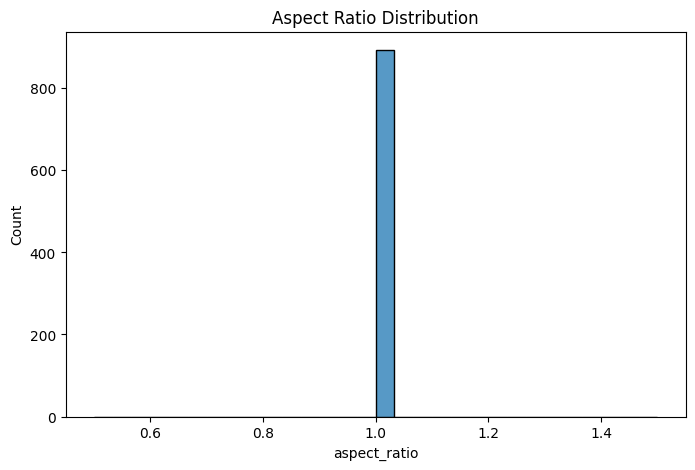

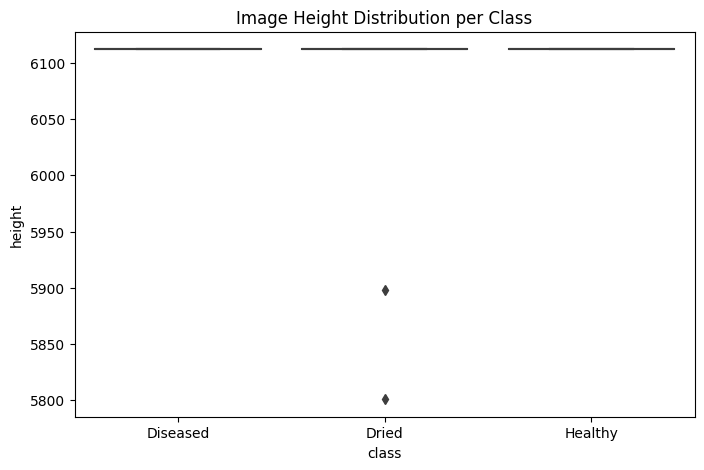

Computing RGB/HSV stats: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]



RGB/HSV mean/std summary:
           R_mean      R_std      G_mean      G_std      B_mean      B_std  \
count   20.000000  20.000000   20.000000  20.000000   20.000000  20.000000   
mean   158.223602  60.500712  166.787008  37.458642  163.011909  41.771130   
std      8.296913   7.185983    7.285863  11.869491    7.006443   8.167971   
min    142.968054  43.435114  145.645051  17.860924  145.667454  24.750282   
25%    153.833568  56.442079  163.837845  29.761833  159.615000  39.147868   
50%    158.466304  60.596207  167.415784  34.063269  162.417403  40.962408   
75%    160.476589  64.240123  172.632145  46.514551  166.925191  46.126167   
max    173.622374  73.600806  176.920709  59.265041  174.220334  56.912105   

           H_mean     S_mean      V_mean  
count   20.000000  20.000000   20.000000  
mean    93.792637  35.354346  170.203615  
std      6.839521   9.252077    6.698205  
min     74.255337  17.503272  150.926033  
25%     91.032063  30.047899  165.949832  
50%     95.4

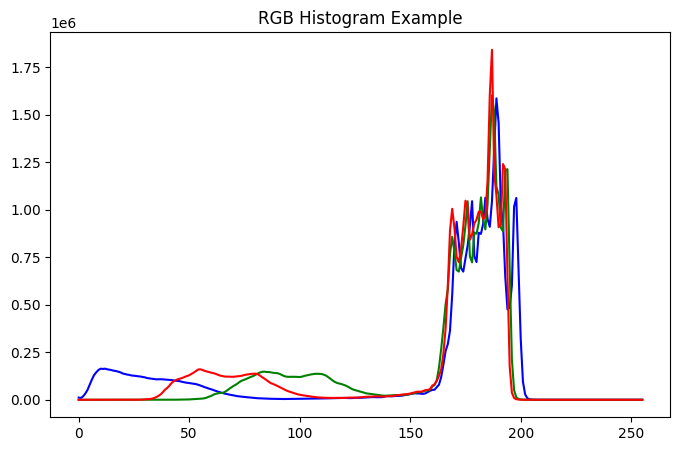

Brightness/Contrast: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]



Brightness mean/std (subset): [164.65112204  41.22281756]


Sharpness: 100%|██████████| 893/893 [09:29<00:00,  1.57it/s]


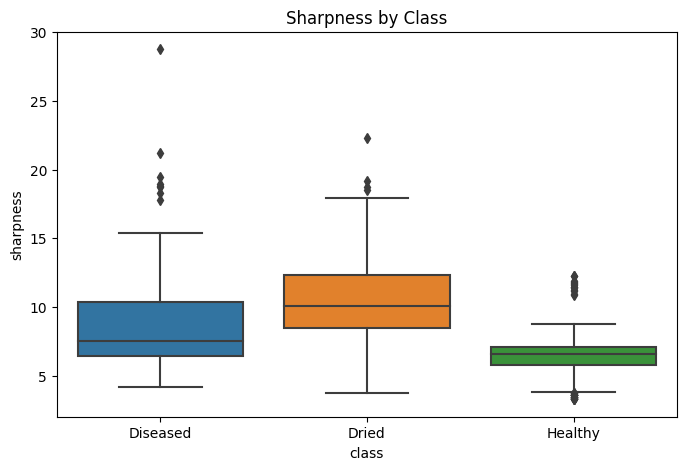

Gray-World Check: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]



Channel means (BGR): [158.22360172 166.78700776 163.01190929]


Checking duplicates: 100%|██████████| 893/893 [07:00<00:00,  2.13it/s]



Found 3 potential duplicates.
Duplicate pair: ('/kaggle/input/betel-leaf-dataset/Controlled Environment/Diseased/CE_Diseased_Leaf_040.jpg', '/kaggle/input/betel-leaf-dataset/Controlled Environment/Diseased/CE_Diseased_Leaf_058.jpg')
Duplicate pair: ('/kaggle/input/betel-leaf-dataset/Controlled Environment/Healthy/CE_Healthy_Leaf_294.jpg', '/kaggle/input/betel-leaf-dataset/Controlled Environment/Healthy/CE_Healthy_Leaf_293.jpg')
Duplicate pair: ('/kaggle/input/betel-leaf-dataset/Controlled Environment/Healthy/CE_Healthy_Leaf_250.jpg', '/kaggle/input/betel-leaf-dataset/Controlled Environment/Healthy/CE_Healthy_Leaf_330.jpg')


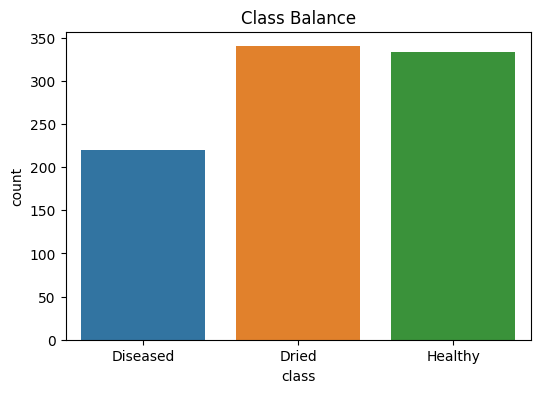


Train: 714 | Test: 179


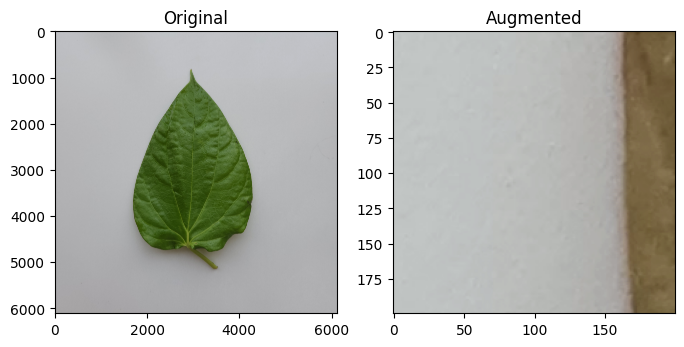

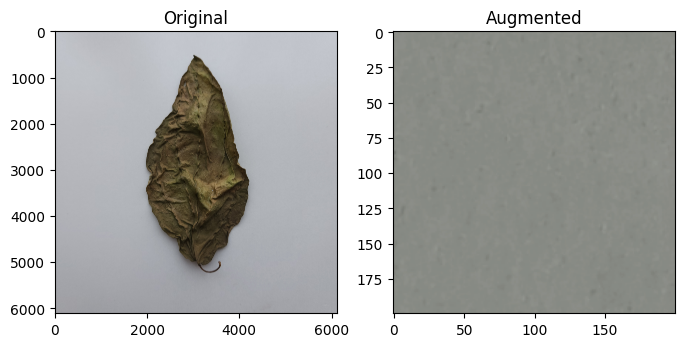

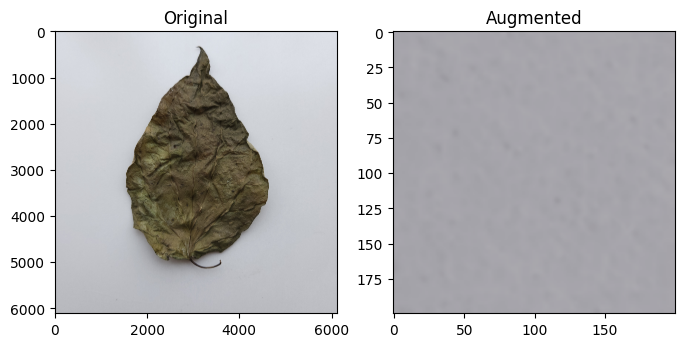


✅ EDA complete — all key outputs displayed.


In [1]:
# ===============================
# CSE475 (Fall 2025) - Task 1: EDA
# Dataset: Betel Leaf Dataset (btdym2t6mt/1)
# Author: <Your Name>
# ===============================

import os, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from PIL import Image
import imagehash
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---- CONFIG ----
base_path = "/kaggle/input/betel-leaf-dataset/Controlled Environment"  # change if different
classes = os.listdir(base_path)
print("Classes found:", classes)

# ===============================
# 1. Load basic dataset info
# ===============================
data = []
for cls in classes:
    folder = os.path.join(base_path, cls)
    for f in os.listdir(folder):
        path = os.path.join(folder, f)
        img = cv2.imread(path)
        if img is not None:
            h, w, c = img.shape
            data.append([path, cls, h, w])

df = pd.DataFrame(data, columns=["path", "class", "height", "width"])
print("\nSample entries:")
print(df.head())
print("\nClass distribution:")
print(df["class"].value_counts())

# ===============================
# 2. Resolution and Aspect Ratio
# ===============================
df["aspect_ratio"] = df["width"] / df["height"]
plt.figure(figsize=(8,5))
sns.histplot(df["aspect_ratio"], bins=30)
plt.title("Aspect Ratio Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x="class", y="height", data=df)
plt.title("Image Height Distribution per Class")
plt.show()

# ===============================
# 3. RGB & HSV Statistics
# ===============================
def color_stats(img):
    stats = {}
    for i, ch in enumerate(["R","G","B"]):
        stats[ch+"_mean"] = np.mean(img[:,:,i])
        stats[ch+"_std"] = np.std(img[:,:,i])
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    stats["H_mean"] = np.mean(hsv[:,:,0])
    stats["S_mean"] = np.mean(hsv[:,:,1])
    stats["V_mean"] = np.mean(hsv[:,:,2])
    return stats

subset = df.sample(20, random_state=42)
rgb_stats = []
for p in tqdm(subset["path"], desc="Computing RGB/HSV stats"):
    img = cv2.imread(p)
    rgb_stats.append(color_stats(img))
rgb_df = pd.DataFrame(rgb_stats)
print("\nRGB/HSV mean/std summary:")
print(rgb_df.describe())

# Plot RGB hist for one random sample
sample_img = cv2.imread(subset.iloc[0]["path"])
colors = ('b','g','r')
plt.figure(figsize=(8,5))
for i,col in enumerate(colors):
    histr = cv2.calcHist([sample_img],[i],None,[256],[0,256])
    plt.plot(histr, color=col)
plt.title("RGB Histogram Example")
plt.show()

# ===============================
# 4. Brightness/Contrast Spread
# ===============================
def brightness_contrast(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray.mean(), gray.std()

br_ct = []
for p in tqdm(subset["path"], desc="Brightness/Contrast"):
    img = cv2.imread(p)
    br_ct.append(brightness_contrast(img))
br_ct = np.array(br_ct)
print("\nBrightness mean/std (subset):", br_ct.mean(axis=0))

# ===============================
# 5. Sharpness/Noise Proxy (Laplacian)
# ===============================
def sharpness(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

df["sharpness"] = [sharpness(cv2.imread(p)) for p in tqdm(df["path"], desc="Sharpness")]
plt.figure(figsize=(8,5))
sns.boxplot(x="class", y="sharpness", data=df)
plt.title("Sharpness by Class")
plt.show()

# ===============================
# 6. White Balance (Gray-World)
# ===============================
means = []
for p in tqdm(subset["path"], desc="Gray-World Check"):
    img = cv2.imread(p)
    means.append(np.mean(img, axis=(0,1)))
means = np.array(means)
print("\nChannel means (BGR):", means.mean(axis=0))

# ===============================
# 7. Duplicate Detection (Perceptual Hash)
# ===============================
hashes = {}
dupes = []
for p in tqdm(df["path"], desc="Checking duplicates"):
    try:
        h = imagehash.phash(Image.open(p))
        if h in hashes:
            dupes.append((p, hashes[h]))
        else:
            hashes[h] = p
    except:
        pass

print(f"\nFound {len(dupes)} potential duplicates.")
if dupes:
    for d in dupes[:5]:
        print("Duplicate pair:", d)

# ===============================
# 8. Class Balance Plot
# ===============================
plt.figure(figsize=(6,4))
sns.countplot(x="class", data=df)
plt.title("Class Balance")
plt.show()

# ===============================
# 9. Train-Test Split (Leakage Safeguard)
# ===============================
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["class"], random_state=42)
print(f"\nTrain: {len(train_df)} | Test: {len(test_df)}")

# ===============================
# 10. Augmentation Probe
# ===============================
transform = A.Compose([
    A.RandomCrop(height=200, width=200),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.5),
    A.GaussianBlur(p=0.3),
    ToTensorV2()
])

sample_paths = list(subset["path"].values)[:3]
for p in sample_paths:
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    augmented = transform(image=img)["image"].permute(1,2,0).numpy()
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(augmented); plt.title("Augmented")
    plt.show()

print("\n✅ EDA complete — all key outputs displayed.")


Checking Healthy: 100%|██████████| 333/333 [01:56<00:00,  2.85it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



📏 Image size summary:
             width       height
count   893.000000   893.000000
mean   6111.412094  6111.412094
std      12.626417    12.626417
min    5801.000000  5801.000000
25%    6112.000000  6112.000000
50%    6112.000000  6112.000000
75%    6112.000000  6112.000000
max    6112.000000  6112.000000


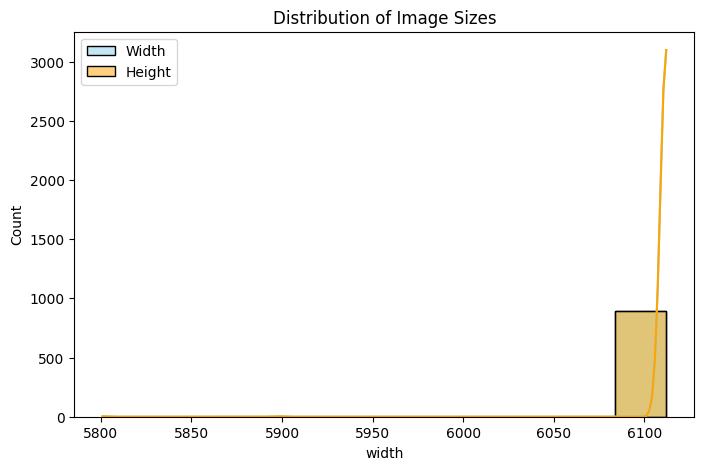

In [2]:
import os, cv2, pandas as pd
from tqdm import tqdm

# 🔹 Path to your dataset folder
# (In Kaggle, this is usually /kaggle/input/<dataset-folder-name>)
dataset_path = "/kaggle/input/betel-leaf-dataset/Controlled Environment"

sizes = []
for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    for f in tqdm(os.listdir(cls_path), desc=f"Checking {cls}"):
        img_path = os.path.join(cls_path, f)
        img = cv2.imread(img_path)
        if img is not None:
            h, w, c = img.shape
            sizes.append([cls, w, h])

df = pd.DataFrame(sizes, columns=["class", "width", "height"])

print("\n📏 Image size summary:")
print(df.describe())

# Optional: visualize distribution
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.histplot(df["width"], color="skyblue", label="Width", kde=True)
sns.histplot(df["height"], color="orange", label="Height", kde=True)
plt.legend(); plt.title("Distribution of Image Sizes")
plt.show()


In [3]:
import os, cv2
from tqdm import tqdm

# Use same path you used in EDA
dataset_path = "/kaggle/input/betel-leaf-dataset/Controlled Environment"  # 👈 তোমার dataset folder

resize_size = (224, 224)  # change if needed (128,128 for faster training)

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    for f in tqdm(os.listdir(cls_path), desc=f"Resizing {cls}"):
        img_path = os.path.join(cls_path, f)
        img = cv2.imread(img_path)
        if img is not None:
            resized = cv2.resize(img, resize_size)
            cv2.imwrite(img_path, resized)  # overwrite existing file

print("\n✅ All images resized directly in the same folder!")


Resizing Healthy: 100%|██████████| 333/333 [01:57<00:00,  2.84it/s]


✅ All images resized directly in the same folder!


In [4]:
import os, pandas as pd
from pathlib import Path

dataset_path = "/kaggle/input/betel-leaf-dataset/Controlled Environment"
classes = sorted(os.listdir(dataset_path))  # ['Diseased', 'Dried', 'Healthy']

data = []
for cls in classes:
    cls_path = Path(dataset_path) / cls
    for f in os.listdir(cls_path):
        data.append({"path": str(cls_path / f), "class": cls, "sample_id": f.split("_")[0]})

df = pd.DataFrame(data)
print("Classes:", classes, "| Total images:", len(df))
df.head()


Classes: ['Diseased', 'Dried', 'Healthy'] | Total images: 893


,path,class,sample_id
0,/kaggle/input/betel-leaf-dataset/Controlled En...,Diseased,CE
1,/kaggle/input/betel-leaf-dataset/Controlled En...,Diseased,CE
2,/kaggle/input/betel-leaf-dataset/Controlled En...,Diseased,CE
3,/kaggle/input/betel-leaf-dataset/Controlled En...,Diseased,CE
4,/kaggle/input/betel-leaf-dataset/Controlled En...,Diseased,CE


Classes: ['Diseased', 'Dried', 'Healthy']
Total images: 893

===== SPLIT 90_9 (Train 90% / Test 10%) =====


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


Epoch 1: Train Acc=0.7438, Val Acc=0.8765


Epoch 2: Train Acc=0.8518, Val Acc=0.9012


Epoch 3: Train Acc=0.8712, Val Acc=0.9383


Epoch 4: Train Acc=0.9169, Val Acc=0.9136


Epoch 5: Train Acc=0.9141, Val Acc=0.9630


Epoch 6: Train Acc=0.9155, Val Acc=0.9630


Epoch 7: Train Acc=0.9224, Val Acc=0.9259


Epoch 8: Train Acc=0.9072, Val Acc=0.9753


Epoch 9: Train Acc=0.9155, Val Acc=0.9383


Epoch 10: Train Acc=0.9252, Val Acc=0.9506


Epoch 11: Train Acc=0.9335, Val Acc=0.9753


Epoch 12: Train Acc=0.9169, Val Acc=0.9630


Epoch 13: Train Acc=0.9363, Val Acc=0.9506


Epoch 14: Train Acc=0.9377, Val Acc=0.9383


Epoch 15: Train Acc=0.9280, Val Acc=0.9383


Epoch 16: Train Acc=0.9529, Val Acc=0.9506


Epoch 17: Train Acc=0.9460, Val Acc=0.9506


Epoch 18: Train Acc=0.9363, Val Acc=0.9753


Epoch 19: Train Acc=0.9488, Val Acc=0.9753


Epoch 20: Train Acc=0.9488, Val Acc=0.9877


Epoch 21: Train Acc=0.9418, Val Acc=0.9877


Epoch 22: Train Acc=0.9488, Val Acc=0.9877


Epoch 23: Train Acc=0.9515, Val Acc=0.9753


Epoch 24: Train Acc=0.9488, Val Acc=0.9630


Epoch 25: Train Acc=0.9515, Val Acc=0.9753
✅ Split 90_9 done in 88.5 min | Test Acc=0.9667


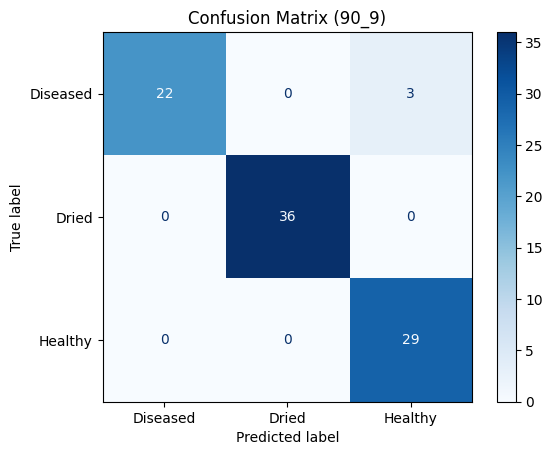


===== SPLIT 80_19 (Train 80% / Test 20%) =====


Epoch 1: Train Acc=0.6916, Val Acc=0.8889


Epoch 2: Train Acc=0.8723, Val Acc=0.8611


Epoch 3: Train Acc=0.8614, Val Acc=0.8889


Epoch 4: Train Acc=0.9268, Val Acc=0.9167


Epoch 5: Train Acc=0.9097, Val Acc=0.9167


Epoch 6: Train Acc=0.9174, Val Acc=0.9167


Epoch 7: Train Acc=0.9221, Val Acc=0.9028


Epoch 8: Train Acc=0.9268, Val Acc=0.9306


Epoch 9: Train Acc=0.9299, Val Acc=0.9167


Epoch 10: Train Acc=0.9330, Val Acc=0.9444


Epoch 11: Train Acc=0.9393, Val Acc=0.9306


Epoch 12: Train Acc=0.9268, Val Acc=0.9583


Epoch 13: Train Acc=0.9564, Val Acc=0.9444


Epoch 14: Train Acc=0.9377, Val Acc=0.9583


Epoch 15: Train Acc=0.9408, Val Acc=0.9306


Epoch 16: Train Acc=0.9517, Val Acc=0.9444


Epoch 17: Train Acc=0.9548, Val Acc=0.9444


Epoch 18: Train Acc=0.9315, Val Acc=0.9583


Epoch 19: Train Acc=0.9393, Val Acc=0.9444


Epoch 20: Train Acc=0.9517, Val Acc=0.9583


Epoch 21: Train Acc=0.9611, Val Acc=0.9444


Epoch 22: Train Acc=0.9626, Val Acc=0.9583


Epoch 23: Train Acc=0.9642, Val Acc=0.9444


Epoch 24: Train Acc=0.9642, Val Acc=0.9444


Epoch 25: Train Acc=0.9439, Val Acc=0.9583
✅ Split 80_19 done in 63.8 min | Test Acc=0.9385


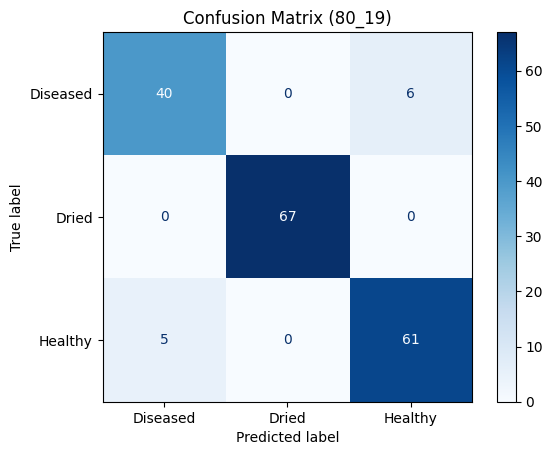


===== SPLIT 70_30 (Train 70% / Test 30%) =====


Epoch 1: Train Acc=0.6868, Val Acc=0.7778


Epoch 2: Train Acc=0.8310, Val Acc=0.8889


Epoch 3: Train Acc=0.8612, Val Acc=0.9048


Epoch 4: Train Acc=0.9093, Val Acc=0.9206


Epoch 5: Train Acc=0.9057, Val Acc=0.9365


Epoch 6: Train Acc=0.9306, Val Acc=0.9206


Epoch 7: Train Acc=0.9093, Val Acc=0.9206


Epoch 8: Train Acc=0.9164, Val Acc=0.9524


Epoch 9: Train Acc=0.9235, Val Acc=0.9683


Epoch 10: Train Acc=0.9324, Val Acc=0.9365


Epoch 11: Train Acc=0.9413, Val Acc=0.9683


Epoch 12: Train Acc=0.9235, Val Acc=0.9365


Epoch 13: Train Acc=0.9520, Val Acc=0.9683


Epoch 14: Train Acc=0.9395, Val Acc=0.9683


Epoch 15: Train Acc=0.9235, Val Acc=0.9524


Epoch 16: Train Acc=0.9395, Val Acc=0.9365


Epoch 17: Train Acc=0.9431, Val Acc=0.9683


Epoch 18: Train Acc=0.9609, Val Acc=0.9524


Epoch 19: Train Acc=0.9395, Val Acc=0.9365


Epoch 20: Train Acc=0.9573, Val Acc=0.9524


Epoch 21: Train Acc=0.9537, Val Acc=0.9683


Epoch 22: Train Acc=0.9359, Val Acc=0.9683


Epoch 23: Train Acc=0.9377, Val Acc=0.9683


Epoch 24: Train Acc=0.9502, Val Acc=0.9841


Epoch 25: Train Acc=0.9591, Val Acc=0.9841
✅ Split 70_30 done in 56.0 min | Test Acc=0.9552


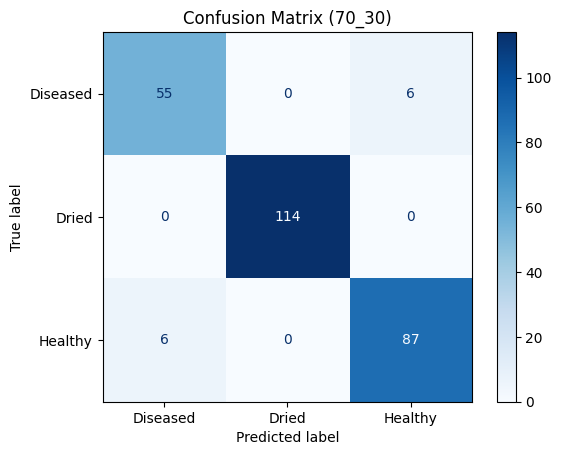


===== SPLIT 60_40 (Train 60% / Test 40%) =====


Epoch 1: Train Acc=0.7152, Val Acc=0.6852


Epoch 2: Train Acc=0.8004, Val Acc=0.7963


Epoch 3: Train Acc=0.8815, Val Acc=0.8889


Epoch 4: Train Acc=0.8753, Val Acc=0.9259


Epoch 5: Train Acc=0.8898, Val Acc=0.9259


Epoch 6: Train Acc=0.9148, Val Acc=0.9259


Epoch 7: Train Acc=0.8857, Val Acc=0.9259


Epoch 8: Train Acc=0.9210, Val Acc=0.9259


Epoch 9: Train Acc=0.9231, Val Acc=0.9815


Epoch 10: Train Acc=0.9356, Val Acc=0.9630


Epoch 11: Train Acc=0.9293, Val Acc=0.9444


Epoch 12: Train Acc=0.9189, Val Acc=0.9259


Epoch 13: Train Acc=0.9418, Val Acc=0.9444


Epoch 14: Train Acc=0.9397, Val Acc=0.9630


Epoch 15: Train Acc=0.9335, Val Acc=0.9630


Epoch 16: Train Acc=0.9439, Val Acc=0.9630


Epoch 17: Train Acc=0.9439, Val Acc=0.9444


Epoch 18: Train Acc=0.9501, Val Acc=0.9815


Epoch 19: Train Acc=0.9439, Val Acc=0.9259


Epoch 20: Train Acc=0.9397, Val Acc=0.9444


Epoch 21: Train Acc=0.9501, Val Acc=0.9815


Epoch 22: Train Acc=0.9459, Val Acc=0.9630


Epoch 23: Train Acc=0.9480, Val Acc=0.9630


Epoch 24: Train Acc=0.9522, Val Acc=1.0000


Epoch 25: Train Acc=0.9418, Val Acc=0.9630
✅ Split 60_40 done in 48.0 min | Test Acc=0.9497


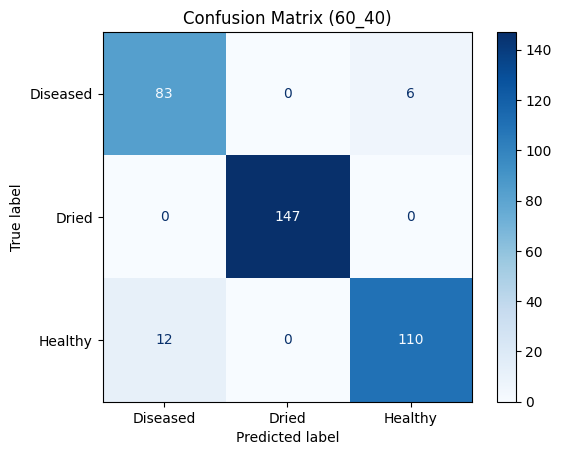


===== SPLIT 50_50 (Train 50% / Test 50%) =====


Epoch 1: Train Acc=0.6633, Val Acc=0.8000


Epoch 2: Train Acc=0.8030, Val Acc=0.9111


Epoch 3: Train Acc=0.8379, Val Acc=0.9556


Epoch 4: Train Acc=0.8803, Val Acc=0.9333


Epoch 5: Train Acc=0.8753, Val Acc=0.9556


Epoch 6: Train Acc=0.8928, Val Acc=0.9111


Epoch 7: Train Acc=0.9127, Val Acc=0.9556


Epoch 8: Train Acc=0.9177, Val Acc=0.9556


Epoch 9: Train Acc=0.9202, Val Acc=0.9333


Epoch 10: Train Acc=0.9052, Val Acc=0.9556


Epoch 11: Train Acc=0.9327, Val Acc=0.9333


Epoch 12: Train Acc=0.9401, Val Acc=0.9556


Epoch 13: Train Acc=0.9377, Val Acc=0.9556


Epoch 14: Train Acc=0.9352, Val Acc=0.9333


Epoch 15: Train Acc=0.9451, Val Acc=0.9556


Epoch 16: Train Acc=0.9152, Val Acc=0.9556


Epoch 17: Train Acc=0.9227, Val Acc=0.9556


Epoch 18: Train Acc=0.9152, Val Acc=0.9556


Epoch 19: Train Acc=0.9352, Val Acc=0.9778


Epoch 20: Train Acc=0.9426, Val Acc=0.9556


Epoch 21: Train Acc=0.9202, Val Acc=0.9778


Epoch 22: Train Acc=0.9327, Val Acc=0.9333


Epoch 23: Train Acc=0.9501, Val Acc=0.9556


Epoch 24: Train Acc=0.9401, Val Acc=0.9333


Epoch 25: Train Acc=0.9551, Val Acc=0.9333
✅ Split 50_50 done in 45.2 min | Test Acc=0.9418


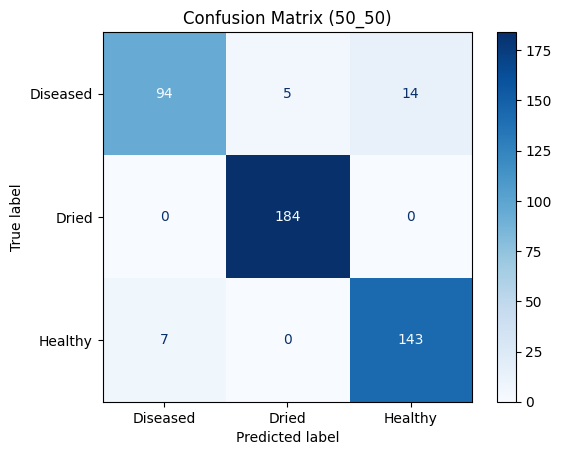


===== SPLIT 40_60 (Train 40% / Test 60%) =====


Epoch 1: Train Acc=0.6542, Val Acc=0.8333


Epoch 2: Train Acc=0.7913, Val Acc=0.7778


Epoch 3: Train Acc=0.8131, Val Acc=0.7500


Epoch 4: Train Acc=0.8505, Val Acc=0.8889


Epoch 5: Train Acc=0.8847, Val Acc=0.8889


Epoch 6: Train Acc=0.8816, Val Acc=0.9444


Epoch 7: Train Acc=0.8910, Val Acc=0.9444


Epoch 8: Train Acc=0.8816, Val Acc=0.9444


Epoch 9: Train Acc=0.9065, Val Acc=0.9444


Epoch 10: Train Acc=0.9315, Val Acc=0.8889


Epoch 11: Train Acc=0.9159, Val Acc=0.8611


Epoch 12: Train Acc=0.9034, Val Acc=0.9444


Epoch 13: Train Acc=0.9221, Val Acc=0.8889


Epoch 14: Train Acc=0.9502, Val Acc=0.9444


Epoch 15: Train Acc=0.9502, Val Acc=0.9444


Epoch 16: Train Acc=0.9346, Val Acc=0.9167


Epoch 17: Train Acc=0.9377, Val Acc=0.9444


Epoch 18: Train Acc=0.9470, Val Acc=0.9444


Epoch 19: Train Acc=0.9159, Val Acc=0.9444


Epoch 20: Train Acc=0.9128, Val Acc=0.9444


Epoch 21: Train Acc=0.9439, Val Acc=0.9444


Epoch 22: Train Acc=0.9408, Val Acc=0.9444


Epoch 23: Train Acc=0.9470, Val Acc=0.9444


Epoch 24: Train Acc=0.9252, Val Acc=0.9167


Epoch 25: Train Acc=0.9377, Val Acc=0.9444
✅ Split 40_60 done in 31.9 min | Test Acc=0.9235


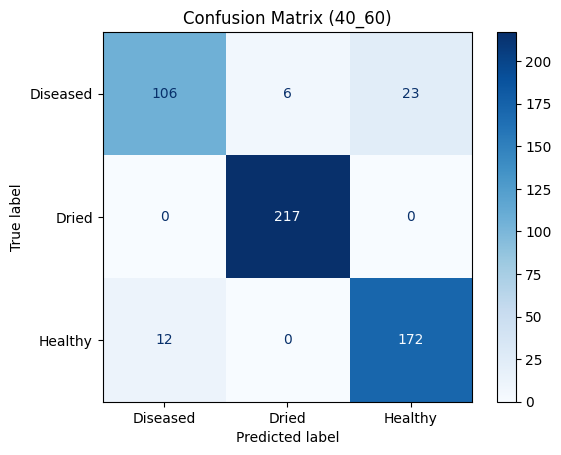


===== SPLIT 30_70 (Train 30% / Test 70%) =====


Epoch 1: Train Acc=0.6458, Val Acc=0.7407


Epoch 2: Train Acc=0.7917, Val Acc=0.7778


Epoch 3: Train Acc=0.7875, Val Acc=0.8889


Epoch 4: Train Acc=0.8417, Val Acc=0.9259


Epoch 5: Train Acc=0.8625, Val Acc=0.9259


Epoch 6: Train Acc=0.8583, Val Acc=0.9630


Epoch 7: Train Acc=0.8833, Val Acc=0.9630


Epoch 8: Train Acc=0.9125, Val Acc=0.9630


Epoch 9: Train Acc=0.9292, Val Acc=0.9259


Epoch 10: Train Acc=0.9125, Val Acc=0.9630


Epoch 11: Train Acc=0.9167, Val Acc=0.9630


Epoch 12: Train Acc=0.9083, Val Acc=0.9259


Epoch 13: Train Acc=0.9250, Val Acc=0.9259


Epoch 14: Train Acc=0.9292, Val Acc=0.9630


Epoch 15: Train Acc=0.9333, Val Acc=0.9259


Epoch 16: Train Acc=0.9042, Val Acc=0.9259


Epoch 17: Train Acc=0.9458, Val Acc=0.9630


Epoch 18: Train Acc=0.9500, Val Acc=0.9630


Epoch 19: Train Acc=0.9458, Val Acc=0.9630


Epoch 20: Train Acc=0.9250, Val Acc=0.9630


Epoch 21: Train Acc=0.9500, Val Acc=0.9630


Epoch 22: Train Acc=0.9500, Val Acc=0.9630


Epoch 23: Train Acc=0.9417, Val Acc=0.9630


Epoch 24: Train Acc=0.9417, Val Acc=0.9630


Epoch 25: Train Acc=0.9625, Val Acc=0.9630
✅ Split 30_70 done in 24.2 min | Test Acc=0.9409


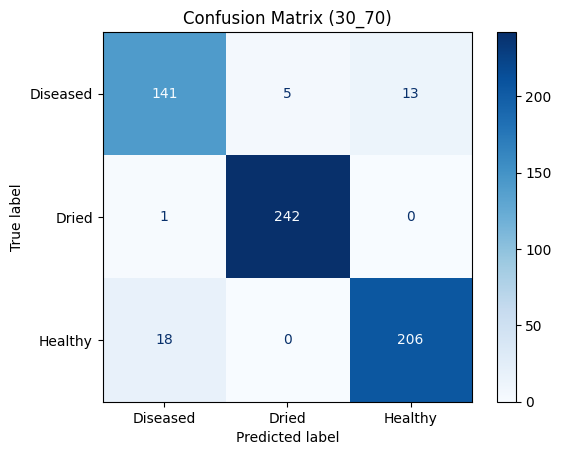


===== SPLIT 20_80 (Train 20% / Test 80%) =====


Epoch 1: Train Acc=0.5188, Val Acc=0.7778


Epoch 2: Train Acc=0.7312, Val Acc=0.8889


Epoch 3: Train Acc=0.7250, Val Acc=0.9444


Epoch 4: Train Acc=0.8187, Val Acc=0.8333


Epoch 5: Train Acc=0.8812, Val Acc=0.8889


Epoch 6: Train Acc=0.8313, Val Acc=0.8889


Epoch 7: Train Acc=0.8500, Val Acc=0.7778


Epoch 8: Train Acc=0.8562, Val Acc=0.7778


Epoch 9: Train Acc=0.8812, Val Acc=0.8333


Epoch 10: Train Acc=0.9000, Val Acc=0.8333


Epoch 11: Train Acc=0.9125, Val Acc=0.8333


Epoch 12: Train Acc=0.9375, Val Acc=0.8333


Epoch 13: Train Acc=0.9000, Val Acc=0.8333


Epoch 14: Train Acc=0.9625, Val Acc=0.8889


Epoch 15: Train Acc=0.9187, Val Acc=0.8333


Epoch 16: Train Acc=0.9437, Val Acc=0.8889


Epoch 17: Train Acc=0.9187, Val Acc=0.8889


Epoch 18: Train Acc=0.9125, Val Acc=0.8333


Epoch 19: Train Acc=0.9187, Val Acc=0.8333


Epoch 20: Train Acc=0.9375, Val Acc=0.8889


Epoch 21: Train Acc=0.9500, Val Acc=0.9444


Epoch 22: Train Acc=0.9437, Val Acc=0.8889


Epoch 23: Train Acc=0.9437, Val Acc=0.8889


Epoch 24: Train Acc=0.9062, Val Acc=0.8333


Epoch 25: Train Acc=0.9500, Val Acc=0.7778
✅ Split 20_80 done in 18.2 min | Test Acc=0.9273


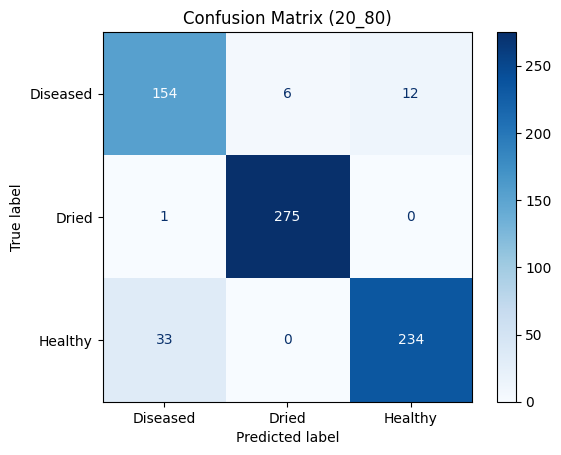


===== SPLIT 10_90 (Train 10% / Test 90%) =====


Epoch 1: Train Acc=0.4125, Val Acc=0.7778


Epoch 2: Train Acc=0.7250, Val Acc=0.7778


Epoch 3: Train Acc=0.7500, Val Acc=0.8889


Epoch 4: Train Acc=0.7875, Val Acc=0.8889


Epoch 5: Train Acc=0.8250, Val Acc=0.8889


Epoch 6: Train Acc=0.8000, Val Acc=0.8889


Epoch 7: Train Acc=0.8875, Val Acc=0.8889


Epoch 8: Train Acc=0.8250, Val Acc=0.8889


Epoch 9: Train Acc=0.8750, Val Acc=0.8889


Epoch 10: Train Acc=0.8125, Val Acc=0.8889


Epoch 11: Train Acc=0.8875, Val Acc=0.8889


Epoch 12: Train Acc=0.8875, Val Acc=0.8889


Epoch 13: Train Acc=0.8875, Val Acc=0.8889


Epoch 14: Train Acc=0.8875, Val Acc=0.8889


Epoch 15: Train Acc=0.9375, Val Acc=0.8889


Epoch 16: Train Acc=0.9500, Val Acc=0.8889


Epoch 17: Train Acc=0.8625, Val Acc=0.8889


Epoch 18: Train Acc=0.8625, Val Acc=0.8889


Epoch 19: Train Acc=0.8750, Val Acc=0.8889


Epoch 20: Train Acc=0.9375, Val Acc=0.8889


Epoch 21: Train Acc=0.9250, Val Acc=0.8889


Epoch 22: Train Acc=0.9375, Val Acc=0.8889


Epoch 23: Train Acc=0.9000, Val Acc=0.8889


Epoch 24: Train Acc=0.9375, Val Acc=0.8889


Epoch 25: Train Acc=0.9250, Val Acc=0.8889
✅ Split 10_90 done in 9.9 min | Test Acc=0.8980


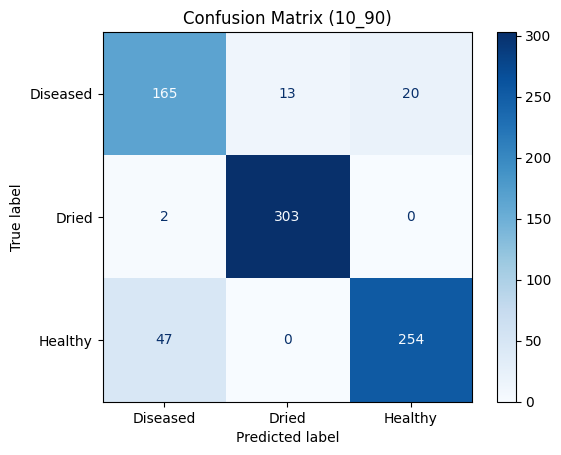


===== FINAL RESULTS =====
   Split  Train_Size  Val_Size  Test_Size  Test_Accuracy
0   90_9         722        81         90       0.966667
1  80_19         642        72        179       0.938547
2  70_30         562        63        268       0.955224
3  60_40         481        54        358       0.949721
4  50_50         401        45        447       0.941834
5  40_60         321        36        536       0.923507
6  30_70         240        27        626       0.940895
7  20_80         160        18        715       0.927273
8  10_90          80         9        804       0.898010


In [5]:
# ===============================================================
# BETEL LEAF HEALTH CLASSIFIER - MULTI RATIO TRAINING
# ===============================================================
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===============================================================
# CONFIG
# ===============================================================
DATA_DIR = "/kaggle/input/betel-leaf-dataset/Controlled Environment"  # change if needed
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
BATCH_SIZE = 8
EPOCHS = 25  # increase if needed
RATIOS = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ===============================================================
# DATASET PREP
# ===============================================================
classes = sorted(os.listdir(DATA_DIR))
print(f"Classes: {classes}")

paths, labels = [], []
for idx, cls in enumerate(classes):
    for file in os.listdir(os.path.join(DATA_DIR, cls)):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            paths.append(os.path.join(DATA_DIR, cls, file))
            labels.append(idx)

df = pd.DataFrame({"path": paths, "label": labels})
print(f"Total images: {len(df)}")

# ===============================================================
# DATASET CLASS
# ===============================================================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class LeafDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        label = self.df.loc[idx, "label"]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ===============================================================
# MODEL
# ===============================================================
def get_model(num_classes):
    model = models.resnet50(weights="IMAGENET1K_V2")
    for param in model.parameters():
        param.requires_grad = False
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model.to(DEVICE)

# ===============================================================
# EVALUATION
# ===============================================================
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, preds, targets = 0, 0, [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            out = model(imgs)
            loss = criterion(out, labels)
            total_loss += loss.item() * imgs.size(0)
            correct += (out.argmax(1) == labels).sum().item()
            preds.append(out.detach().cpu())
            targets.append(labels.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    acc = correct / len(loader.dataset)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, acc, preds, targets

# ===============================================================
# MAIN LOOP FOR 9 RATIOS
# ===============================================================
overall_results = []

for r in RATIOS:
    split_name = f"{int(r*100)}_{int((1-r)*100)}"
    print(f"\n===== SPLIT {split_name} (Train {r*100:.0f}% / Test {(1-r)*100:.0f}%) =====")

    tr_idx, te_idx = train_test_split(np.arange(len(df)), train_size=r, random_state=SEED, shuffle=True)
    df_trfull, df_te = df.iloc[tr_idx], df.iloc[te_idx]
    tr2_idx, va2_idx = train_test_split(np.arange(len(df_trfull)), train_size=0.9, random_state=SEED, shuffle=True)
    df_tr, df_va = df_trfull.iloc[tr2_idx], df_trfull.iloc[va2_idx]

    train_ds = LeafDataset(df_tr, transform_train)
    val_ds = LeafDataset(df_va, transform_val)
    test_ds = LeafDataset(df_te, transform_val)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = get_model(len(classes))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

    history = {"train_acc": [], "val_acc": []}
    start = time.time()

    for epoch in range(1, EPOCHS + 1):
        model.train()
        total_loss, correct = 0, 0
        for imgs, labels in tqdm(train_dl, desc=f"[{split_name}] Epoch {epoch}/{EPOCHS}", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            correct += (out.argmax(1) == labels).sum().item()

        tr_acc = correct / len(train_dl.dataset)
        va_loss, va_acc, _, _ = evaluate(model, val_dl, criterion)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        print(f"Epoch {epoch}: Train Acc={tr_acc:.4f}, Val Acc={va_acc:.4f}")

    duration = time.time() - start
    te_loss, te_acc, te_preds, te_labels = evaluate(model, test_dl, criterion)
    print(f"✅ Split {split_name} done in {duration/60:.1f} min | Test Acc={te_acc:.4f}")

    cm = confusion_matrix(te_labels, te_preds.argmax(1), labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix ({split_name})")
    plt.show()

    overall_results.append({
        "Split": split_name,
        "Train_Size": len(df_tr),
        "Val_Size": len(df_va),
        "Test_Size": len(df_te),
        "Test_Accuracy": te_acc
    })

    del model, train_dl, val_dl, test_dl
    torch.cuda.empty_cache()

# ===============================================================
# FINAL SUMMARY
# ===============================================================
res_df = pd.DataFrame(overall_results)
print("\n===== FINAL RESULTS =====")
print(res_df)
